In [1]:
import numpy as np
import pandas as pd
import requests
import json

In [348]:
#loading json file into an array and dataframe
customer_journeys = json.load(open('customer_journeys_sample.json'))
cj_df = pd.read_json('customer_journeys_sample.json')

## Data Preparation for API calls

In [350]:
# Finding sessions that are occuring after conversion session to remove them. 
#Because API do not accept such sessions.

unwanted_sessions = []
for conversion_id in conversion_ids:
    temp = cj_df[cj_df.conversion_id == conversion_id].sort_values('timestamp')
    for i in (range(temp.shape[0])):
        if 1 in temp.conversion.values and (temp[-1:].conversion.values[0] == 0):
            unwanted_sessions.append(temp[-1:].index[0])
            temp = temp[:-1]
unwanted_sessions.reverse()
for i in unwanted_sessions:
    del customer_journeys[i]            
#cj_df.to_json('filtered_cj.json',orient="records" , date_format = 'iso')


# Dividing customer journeys data into subsets/chunks for API calls, 
#making sure no same conversion_id goes into two different subsets
ids = []
limit = 170
i = 0
while (i < len(customer_journeys)):
    temp = customer_journeys[i:i+limit]
    while((i+len(temp) < len(customer_journeys)) and temp[len(temp)-1]['conversion_id'] == customer_journeys[i+len(temp)]['conversion_id']) :
        temp.append(customer_journeys[i+limit])
        i += 1
    ids.append(temp) 
    i = i+limit

## Calling API while maintaining API limit

In [357]:
# API calls for around 60 CJ chunks
api_key = '1fd53226-133c-4fe4-b749-ea026940cbfa'
conv_type_id = 'test'
api_url = "https://api.ihc-attribution.com/v1/compute_ihc?conv_type_id={conv_type_id}".format(conv_type_id = conv_type_id)

results = []
for chunk in ids:
    
    body = {
    'customer_journeys': chunk
    }
    response = requests.post(
            api_url, 
            data=json.dumps(body), 
            headers= {
                'Content-Type': 'application/json',    
                'x-api-key': api_key
            }
        )

    results.append(response.json())
    #dfs.append(pd.DataFrame(response['value'].json()))

In [369]:
#saving json of API returns
with open('ihc.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

## Converting API returns into one Data Frame

In [365]:
# creating Dataframe
dfs = []
for i in range(0,len(results)):
    dfs.append(pd.DataFrame(results[i]['value']))
# Concat all dataframes
IHC_df = dfs[0]
for other_df in dfs[1:]:
    IHC_df = pd.concat([IHC_df, other_df])   

IHC_df = IHC_df.reset_index(drop=True)
IHC_df.to_csv('IHC.csv')

# merging both dataframes using inner join to skip missing rows from API
merged_df = pd.merge(cj_df, IHC_df, how = 'inner', on = ['conversion_id', 'session_id'])
merged_df.to_csv('merged_df.csv')

In [713]:
merged_df

,conversion_id,session_id,timestamp,channel_label,holder_engagement,closer_engagement,conversion,initializer,holder,closer,ihc
0,1be2b93a-6b36-4481-bed1-a7b0766847f0,2021-06-06_0001__aaf3b324-758d-d819-a2ee-4e51e...,2021-06-06 11:22:08,direct,0,1,0,0.0000,0.0000,0.0,0.0000
1,1be2b93a-6b36-4481-bed1-a7b0766847f0,2021-07-13_0001__aaf3b324-758d-d819-a2ee-4e51e...,2021-07-13 15:01:29,crm,1,0,0,0.8221,0.7667,0.0,0.5829
2,1be2b93a-6b36-4481-bed1-a7b0766847f0,2021-07-19_0001__2594bffe-76af-4b40-b0f7-12a8f...,2021-07-19 08:10:11,crm,1,1,1,0.1779,0.2333,1.0,0.4171
3,52c8c88f-cf76-4b3c-bb02-d06b6215db29,2021-05-21_0001__7084ac0f-3021-e583-2432-a8a53...,2021-05-21 07:30:14,direct,0,1,0,0.0000,0.0000,0.0,0.0000
4,52c8c88f-cf76-4b3c-bb02-d06b6215db29,2021-05-27_0001__7084ac0f-3021-e583-2432-a8a53...,2021-05-27 14:07:46,organic search (non-brand),1,0,0,0.0000,0.0000,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
10212,50d632d5-faeb-42ff-88d0-bba52707db9e,2021-07-18_0001__2ec438da-006d-8836-72a2-56f3c...,2021-07-18 05:17:26,direct,1,1,1,0.0000,0.2298,1.0,0.3561
10213,d380ebae-ac63-4ba1-8e58-e2ac6f7d669f,2021-06-28_0001__2c536ffd-2b73-f913-e249-10023...,2021-06-28 11:50:26,organic search (non-brand),1,0,0,1.0000,0.2094,0.0,0.4190
10214,d380ebae-ac63-4ba1-8e58-e2ac6f7d669f,2021-06-29_0001__50133b8e-41b6-c8f5-8b0c-9523f...,2021-06-29 11:45:57,search-brand,1,0,0,0.0000,0.7906,0.0,0.3170
10215,d380ebae-ac63-4ba1-8e58-e2ac6f7d669f,2021-06-30_0001__79eeafcb-d675-498d-864e-5f559...,2021-06-30 12:06:32,direct,0,1,1,0.0000,0.0000,1.0,0.2640


### Analysing a Customer Journey with IHC score

<AxesSubplot:title={'center':'IHC values for a customer journey'}, xlabel='channel_label'>

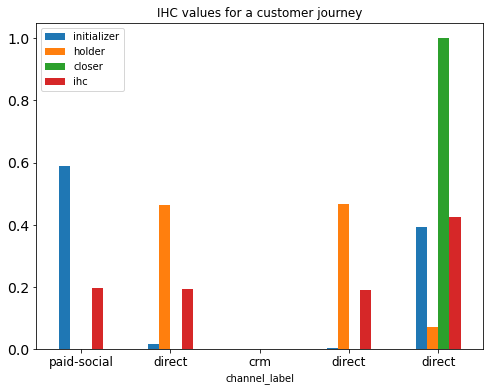

In [763]:
merged_df[merged_df.conversion_id == '0e3626c9-d71e-4557-8ca1-308e1490a946'][['channel_label', 'initializer', 'holder', 
                                                                              'closer', 'ihc']].plot(x='channel_label',
                                                                                kind='bar',
                                                                                stacked=False,
                                                                                title='IHC values for a customer journey',
                                                                                rot = 0, figsize=(8,6))

From this Customer Journey, we can can see that 'paid-social' channel has most initializer value as customer came first time through it. And direct channel has highest closer score in last session as conversion happens in that session.

# Aggregated stats

In [561]:
# plotting each channel_label along with its stats
channels = merged_df.channel_label.unique()

In [714]:
initializer, closer, holder, ihc, conversions, sessions = [], [], [], [], [], []
for channel in channels:
    initializer.append(merged_df['initializer'][merged_df.channel_label == channel].mean())
    closer.append(merged_df['closer'][merged_df.channel_label == channel].mean())
    holder.append(merged_df['holder'][merged_df.channel_label == channel].mean())
    ihc.append(merged_df['ihc'][merged_df.channel_label == channel].mean())
    conversions.append(merged_df['conversion'][merged_df.channel_label == channel].sum())
    sessions.append(merged_df[merged_df.channel_label == channel].shape[0])

aggregated_stats = pd.DataFrame({'channel': channels, 'initializer': initializer, 'holder': holder,
                                'closer': closer,'ihc': ihc, 'conversions': conversions, 'sessions': sessions})    

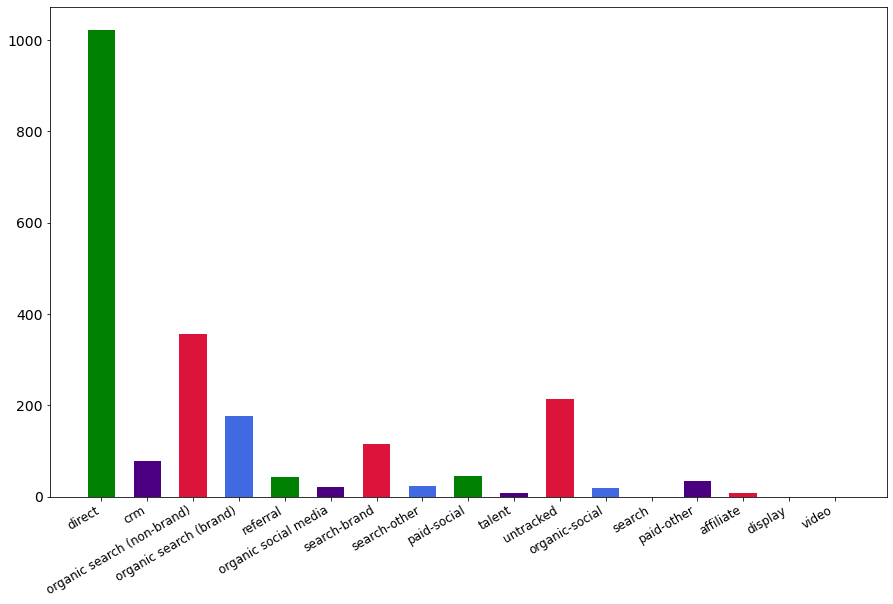

In [765]:
import matplotlib 
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=14) 

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)

plt.bar(x= channels, height = conversions , width = 0.6, color= ['g', 'indigo', 'crimson', 'royalblue'])
plt.gcf().autofmt_xdate()

In [720]:
aggregated_stats = aggregated_stats.sort_values(by = ['conversions', 'sessions'], ascending=False).reset_index(drop=True)

In [721]:
aggregated_stats

,channel,initializer,holder,closer,ihc,conversions,sessions
0,direct,0.197155,0.130027,0.224192,0.203066,1021,4742
1,organic search (non-brand),0.147840,0.294339,0.350162,0.277064,357,1033
2,untracked,1.000000,0.000000,1.000000,1.000000,213,213
3,organic search (brand),0.367073,0.228254,0.406784,0.388424,176,446
4,search-brand,0.385250,0.224682,0.247021,0.312030,115,918
5,crm,0.237968,0.179683,0.200495,0.228512,77,404
6,paid-social,0.210725,0.127911,0.115100,0.170776,44,1269
7,referral,0.278297,0.138496,0.266865,0.253325,43,171
8,paid-other,0.315873,0.133562,0.327711,0.301438,35,104
9,search-other,0.348301,0.248291,0.211365,0.297334,24,222


#### Analysis:
- From the aggregated results above, we can observe that display, video and search have zero conversions and infact very few sessions as well. Company can cut out budget from these channels if they are spending any amount for the purpose of new customers or to get conversions.


- Affiliate and talent are also not successful channels in terms of conversions.


- 1021 conversions (47.3%) are made through direct channel (returning customers),  whereas second highest is through organic search non brand. 

### Visualizing mean I-H-C Values for top 7 channels

<AxesSubplot:title={'center':'IHC Values'}, xlabel='channel'>

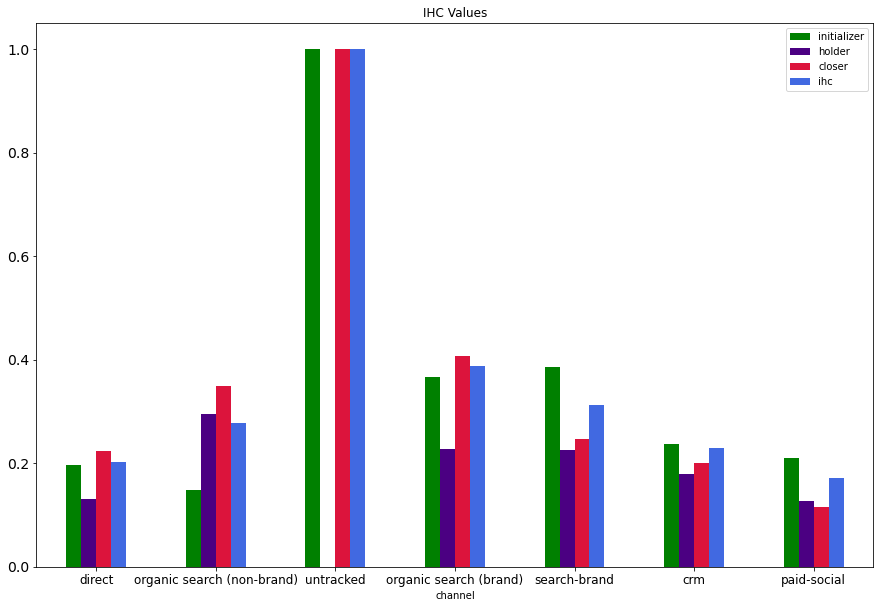

In [756]:
aggregated_stats[:7][['channel','initializer', 'holder', 'closer', 'ihc']].plot(kind ='bar', x = 'channel' , 
                                                                                title='IHC Values', 
                                                                                color=('g', 'indigo', 'crimson', 'royalblue'), 
                                                                                figsize=(15, 10), rot=0)

- 'Untracked' has good mean initializer, holder and ihc values but it is unknown from where this traffic is coming and cannot be used for any improvements in future, so I am skipping it from the analysis.


- 'Organic search(brand)' and 'search-brand' have very good initializer score, so both channels are giving most of the new customers. Company can focus on these two channels if they need to attract more new customers. Customers coming from 'organic search (brand)' have highest closer value as well which indicates high conversion rate.


- Although 'direct' channel has largest number of conversions, but IHC mean values are comparatively less than others. This indicates that other channels are introduicing customer or starting their customer journey but at the end customer comes directly to the website to finally purchase. Here, we can see clear benefits of IHC values. Because of it, we can differentiate between very important and less important channels for future goals irrespective of how many conversions are they giving.